In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, Dataset

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [20]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
]) # Normalize to [-1, 1]


trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = trainvalset.classes
num_classes = len(classes)

# print(classes)

trainset, valset = torch.utils.data.random_split(trainvalset, [0.9, 0.1])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [22]:
# ResNet model

class BasicBlock(nn.Module):
    expansion = 1  # For ResNet18, expansion factor is 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolution layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Second convolution layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection if input and output channels don't match
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Residual layers
        self.layer1 = self._make_layer(64, 64, stride=1)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        self.layer4 = self._make_layer(256, 512, stride=2)

        # Fully connected layer
        self.fc = nn.Linear(512, 10) # 10 for CIFAR-10

    def _make_layer(self, in_channels, out_channels, stride, num_blocks=2):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)  # Assuming CIFAR-10, which has 32x32 input
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [23]:
def evaluation(dataloader, model):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
    return correct / total * 100

In [24]:
class AugmentedDataset(Dataset):
    def __init__(self, base_dataset, extra_transforms=None):
        self.base_dataset = base_dataset
        self.extra_transforms = extra_transforms

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]

        # Apply the additional transformations if specified
        if self.extra_transforms:
            img = self.extra_transforms(img)

        return img, label

    def __len__(self):
        return len(self.base_dataset)

transform_1 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip()
])

transform_2 = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip()
])

In [ ]:
batch_size = 128

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# Model Combinations Evaluation

In [26]:
# Load models and evaluate
results = []
train_accuracies = []
val_accuracies = []

# Iterate over each saved model
for lr in ['1e-04', '1e-05']:
    for wd in ['1e-04', '1e-05']:
        for trans in [0, 1]:
            model_path = f'./hyperparam-tune/best_model_lr{lr}_wd{wd}_trans{trans}.pth'
            
            if trans == 0:
                augmented_trainset = AugmentedDataset(trainset, extra_transforms=transform_1)
            else:
                augmented_trainset = AugmentedDataset(trainset, extra_transforms=transform_2)
            
            trainloader = DataLoader(augmented_trainset, batch_size=batch_size, shuffle=True)
            
            # Load model
            resnet = ResNet18()
            resnet = resnet.to(device)
            resnet.load_state_dict(torch.load(model_path, map_location=device))
            
            # Evaluate model on train and validation sets
            train_accuracy = evaluation(trainloader, resnet)
            val_accuracy = evaluation(valloader, resnet)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            
            # Store results in a dictionary
            results.append({
                "Learning Rate": lr,
                "Weight Decay": wd,
                "Transformation": trans,
                "Training Accuracy": train_accuracy,
                "Validation Accuracy": val_accuracy
            })

C:\Users\irfan\AppData\Local\Temp\ipykernel_28320\2792910172.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load(model_path, map_location=

In [29]:
# Create a DataFrame for the summary table
df_results = pd.DataFrame(results)
df_results['Accuracy Difference'] = df_results['Training Accuracy'] - df_results['Validation Accuracy']
print(df_results)

  Learning Rate Weight Decay  Transformation  Training Accuracy  \
0         1e-04        1e-04               0          94.040000   
1         1e-04        1e-04               1          92.131111   
2         1e-04        1e-05               0          92.951111   
3         1e-04        1e-05               1          93.188889   
4         1e-05        1e-04               0          88.668889   
5         1e-05        1e-04               1          84.093333   
6         1e-05        1e-05               0          86.728889   
7         1e-05        1e-05               1          84.102222   

   Validation Accuracy  Accuracy Difference  
0                94.48            -0.440000  
1                95.20            -3.068889  
2                93.44            -0.488889  
3                95.48            -2.291111  
4                90.16            -1.491111  
5                87.88            -3.786667  
6                87.66            -0.931111  
7                87.50      

# Performance Analysis on Test Set

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Test the model

resnet = ResNet18()
resnet = resnet.to(device)

resnet.load_state_dict(torch.load('./hyperparam-tune/best_model_lr1e-04_wd1e-04_trans0.pth', map_location=device))

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

C:\Users\irfan\AppData\Local\Temp\ipykernel_28320\3340413348.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load('./hyperparam-tune/best_mo

In [40]:
test_accuracy = evaluation(testloader, resnet)

print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 88.29%


In [41]:
# Calculate predictions on test set
all_preds_test = []
all_labels_test = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

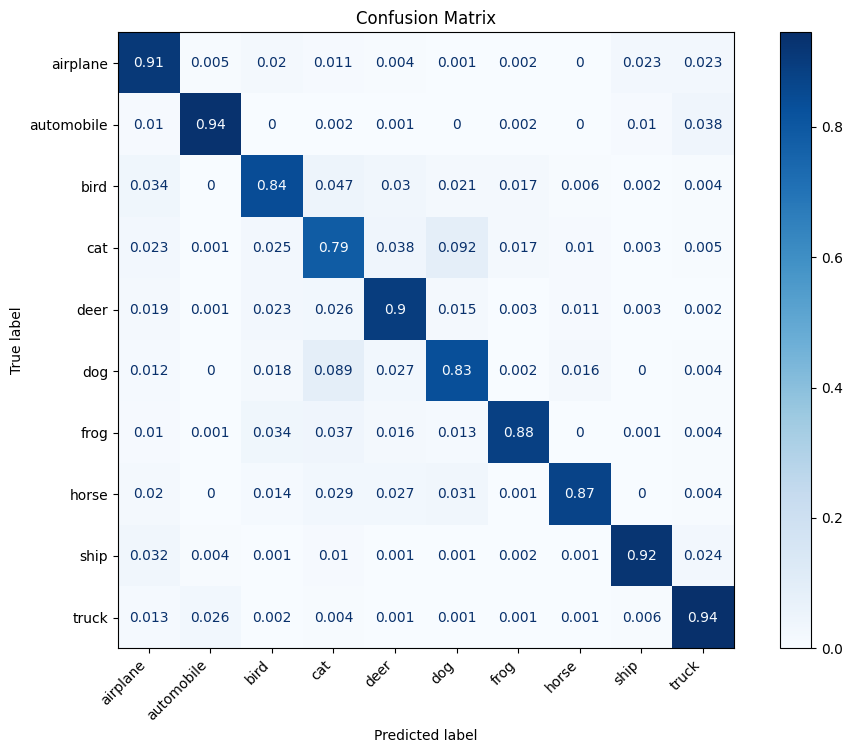

In [42]:
# Generate confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(all_labels_test, all_preds_test)
cm_normalized = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.show()

In [43]:
# Class-wise accuracy (correctly predicted / total true instances)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Mean accuracy
mean_accuracy = np.mean(class_accuracies)

# Median accuracy
median_accuracy = np.median(class_accuracies)

# Class with highest accuracy
max_accuracy_class = np.argmax(class_accuracies)
max_accuracy_value = class_accuracies[max_accuracy_class]

# Class with lowest accuracy
min_accuracy_class = np.argmin(class_accuracies)
min_accuracy_value = class_accuracies[min_accuracy_class]

# Get misclassifications by subtracting the diagonal (correct classifications) from the confusion matrix
misclassifications = cm - np.diag(np.diagonal(cm))

# Find the indices of the top 3 most common misclassifications
misclassification_counts = misclassifications.flatten()
top_3_indices = np.argsort(misclassification_counts)[::-1][:3]  # Sort and pick top 3

# Extract class names and the count of misclassifications
misclassifications_info = []
for idx in top_3_indices:
    i, j = np.unravel_index(idx, misclassifications.shape)
    misclassifications_info.append(
        (classes[i], classes[j], misclassifications[i, j])
    )

print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Median Accuracy: {median_accuracy:.4f}")
print('#' * 20)
print(f"Class with Highest Accuracy: {classes[max_accuracy_class]} ({max_accuracy_value:.4f})")
print(f"Class with Lowest Accuracy: {classes[min_accuracy_class]} ({min_accuracy_value:.4f})")
print('#' * 20)
print("Top 3 Most Common Misclassifications:")
for misclass in misclassifications_info:
    print(f"Class {misclass[0]} misclassified as {misclass[1]}: {misclass[2]} times")

Mean Accuracy: 0.8829
Median Accuracy: 0.8905
####################
Class with Highest Accuracy: truck (0.9450)
Class with Lowest Accuracy: cat (0.7860)
####################
Top 3 Most Common Misclassifications:
Class cat misclassified as dog: 92 times
Class dog misclassified as cat: 89 times
Class bird misclassified as cat: 47 times
